# Logistic Regression [Customer Churn Data]

#### Load Libraries

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### Load Data

In [2]:
# Import data into a pandas dataframe
data = pd.read_csv('Telco-Customer-Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
# Changing 'charges_total' to numeric and 'senior_citizen' to object type.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object)

# Filling missing values with 0 in 'charges_total'
data['TotalCharges'] = data['TotalCharges'].fillna(0)
data['TotalCharges'].isna().sum()

# Converting categorical variables to dummy variables, dropping 'customer_ID'
data1 = data.drop('customerID', axis = 1)

categoricals = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

for col in categoricals:
    dummies = pd.get_dummies(data1[col], prefix=col)
    data1 = pd.concat([data1, dummies], axis=1)
    data1.drop(col, axis=1, inplace=True)
    
# Turning churn from `Yes` to 1s and `No` to 0s
data1['Churn'] = data1['Churn'].replace({'Yes':1,'No':0}) 

# Dropping `churn` from data1
data2 = data1.drop('Churn', axis = 1)

# Normalizing the numerical data
for column in data2.select_dtypes(include=[float, int]):
        col_mean = data2[column].mean()
        col_var = data2[column].var(ddof = 0)
        data2[column] = (data2[column] - col_mean) / np.sqrt(col_var)

data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   float64
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7043 non-null   float64
 3   gender_Female                            7043 non-null   uint8  
 4   gender_Male                              7043 non-null   uint8  
 5   SeniorCitizen_0                          7043 non-null   uint8  
 6   SeniorCitizen_1                          7043 non-null   uint8  
 7   Partner_No                               7043 non-null   uint8  
 8   Partner_Yes                              7043 non-null   uint8  
 9   Dependents_No                            7043 non-null   uint8  
 10  Dependents_Yes                           7043 no

/var/folders/8c/_yj2f2f954384g_b7gdsvlz00000gn/T/ipykernel_41054/4149908275.py:19: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummies = pd.get_dummies(data1[col], prefix=col)


### Exploratory Data Analysis

You can leverage what done in one of the previous assignments, recreate it and expand it.

### Feature Engineering and Analysis
Think about any possible feature that is predictive of the target.  
Measure how each feature is predictive of the target and select all those relevant for the model.

### Configure the model using an appropriate classification technique

In [4]:
def predict(x, q):
    """
    Logistic function or Sigmoid function
    """
    Z = x.dot(q)
    return 1/(1 + np.exp(-Z))

def cost_function(x, q, y_true):
    y_pred = predict(x, q)
    """Computes the error between the predicted and true target values."""
    m = len(y_pred)
    return -1/m * np.sum(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred))

def gradient(x, q, y_true):
    m = x.shape[0]
    y_pred = predict(x, q)
    grad = 1/m * x.T.dot(y_pred - y_true)
    return grad

def log_reg_sgd(x, y_true, q, learning_rate, num_iterations):
    """
    Stochastic gradient descent for two class (0,1) logistic regression
    """
    err = []
    for i in range(num_iterations):
        # Randomly select a data point
        idx = np.random.randint(x.shape[0])
        xi = x[idx:idx+1]
        yi = y_true[idx]
        
        # Calculate the gradient on the selected data point
        grad = gradient(xi, q, yi)
        
        # Update the parameters
        q = q - (learning_rate * grad)
        
        # Calculate cost and append to `err` list
        cost = cost_function(x, q, y_true)
        err.append(cost)
    return q, err

def log_reg_regularized_sgd(x, y_true, q, learning_rate, lamda, num_iterations):
    """
    Stochastic gradient descent for logistic regression of two classes (0,1) with regularization
    """
    err = []
    for i in range(num_iterations):
        # Randomly select a data point
        idx = np.random.randint(x.shape[0])
        xi = x[idx:idx+1]
        yi = y_true[idx]
        
        # Calculate the gradient on the selected data point
        grad = gradient(xi, q, yi)
        
        # Update the parameters
        q = q - learning_rate * (grad - (lamda * q)/len(q))
        
        # Calculate cost and append to `err` list
        cost = cost_function(x, q, y_true)
        err.append(cost)
    return q, err

def plotChart(num_iterations, cost):
    fig, ax = plt.subplots()
    ax.plot(np.arange(num_iterations), cost, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title('Error vs Iterations')
    plt.style.use('fivethirtyeight')
    plt.show()

### Model 1: Using all variables with categorical variables made us dummies (47 features)

In [5]:
# Dropping `churn` column
X1 = data2.copy()

# Inserting column of ones for XO parameter Q0
X1.insert(0, 'X0', 1)
target = data1['Churn']

In [6]:
# Initializing hyperparameters
alpha = 0.001
num_iters = 10000
lamda = 4

# Initlaizing parameters `q`s
params1 = np.zeros(X1.shape[1])

In [8]:
# Logistric Regression
parameters1_1, errors1_1 = log_reg_sgd(X1, target, params1, alpha, num_iters) 

In [10]:
# Regularized Logistic Regression
parameters1_2, errors1_2 = log_reg_regularized_sgd(X1, target, params1, alpha, lamda, num_iters)

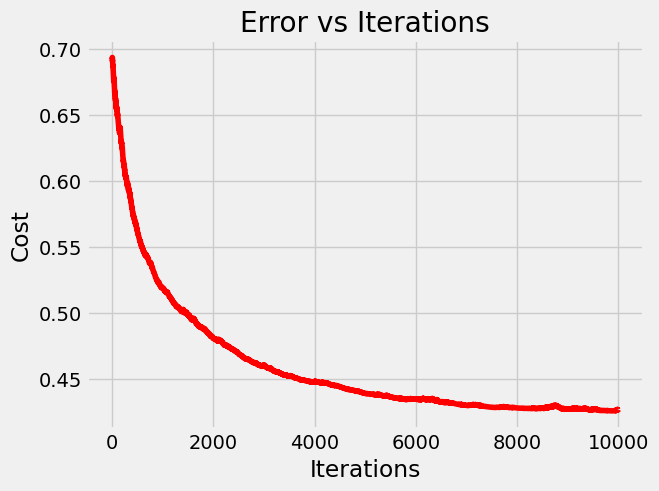

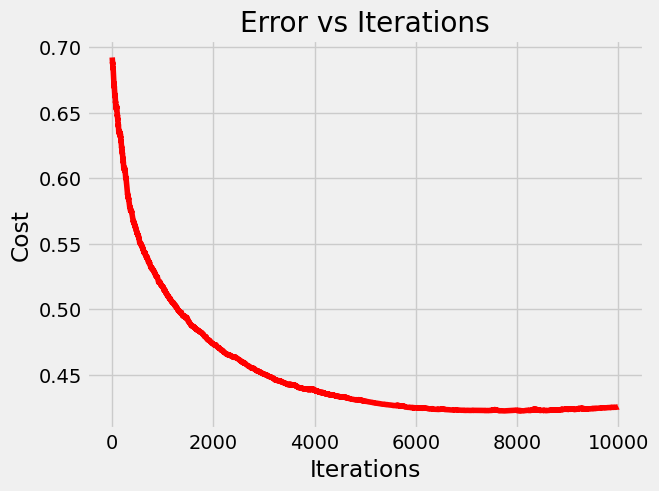

(None, None)

In [12]:
plotChart(num_iters, errors1_1), plotChart(num_iters, errors1_2)

#### Chose the correct metric for assessment of the model

In [15]:
y_predicted1 = predict(X1, parameters1_2)

# Converting predicted probabilities to binary labels
y_pred1 = (y_predicted1 >= 0.5).astype(int)

# Create confusion matrix
tn1, fp1, fn1, tp1 = confusion_matrix(target, y_pred1).ravel()

# Calculate evaluation metrics
accuracy1 = accuracy_score(target, y_pred1)
precision1 = precision_score(target, y_pred1)
recall1 = recall_score(target, y_pred1)
f11 = f1_score(target, y_pred1)

# Print confusion matrix and evaluation metrics
print('Confusion Matrix:')
print('True Negative: ', tn1, '\tFalse Positive: ', fp1)
print('False Negative: ', fn1, '\tTrue Positive: ', tp1)

print('\nEvaluation Metrics: ')
print('Accuracy: ', accuracy1)
print('Precision: ', precision1)
print('Recall/Sensitivity: ', recall1)
print('F1 Score/Specificity: ', f11)

# Calculate AUC
auc1 = roc_auc_score(target, y_predicted1)
print('AUC: ', auc1)

Confusion Matrix:
True Negative:  4634 	False Positive:  540
False Negative:  835 	True Positive:  1034

Evaluation Metrics: 
Accuracy:  0.8047706943064035
Precision:  0.6569250317662008
Recall/Sensitivity:  0.5532370251471375
F1 Score/Specificity:  0.6006389776357827
AUC:  0.841395622802658


When 0.5 < AUC < 1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values.

### Model 2: Using most influential variables from correlation graph (19 variables)

<AxesSubplot:>

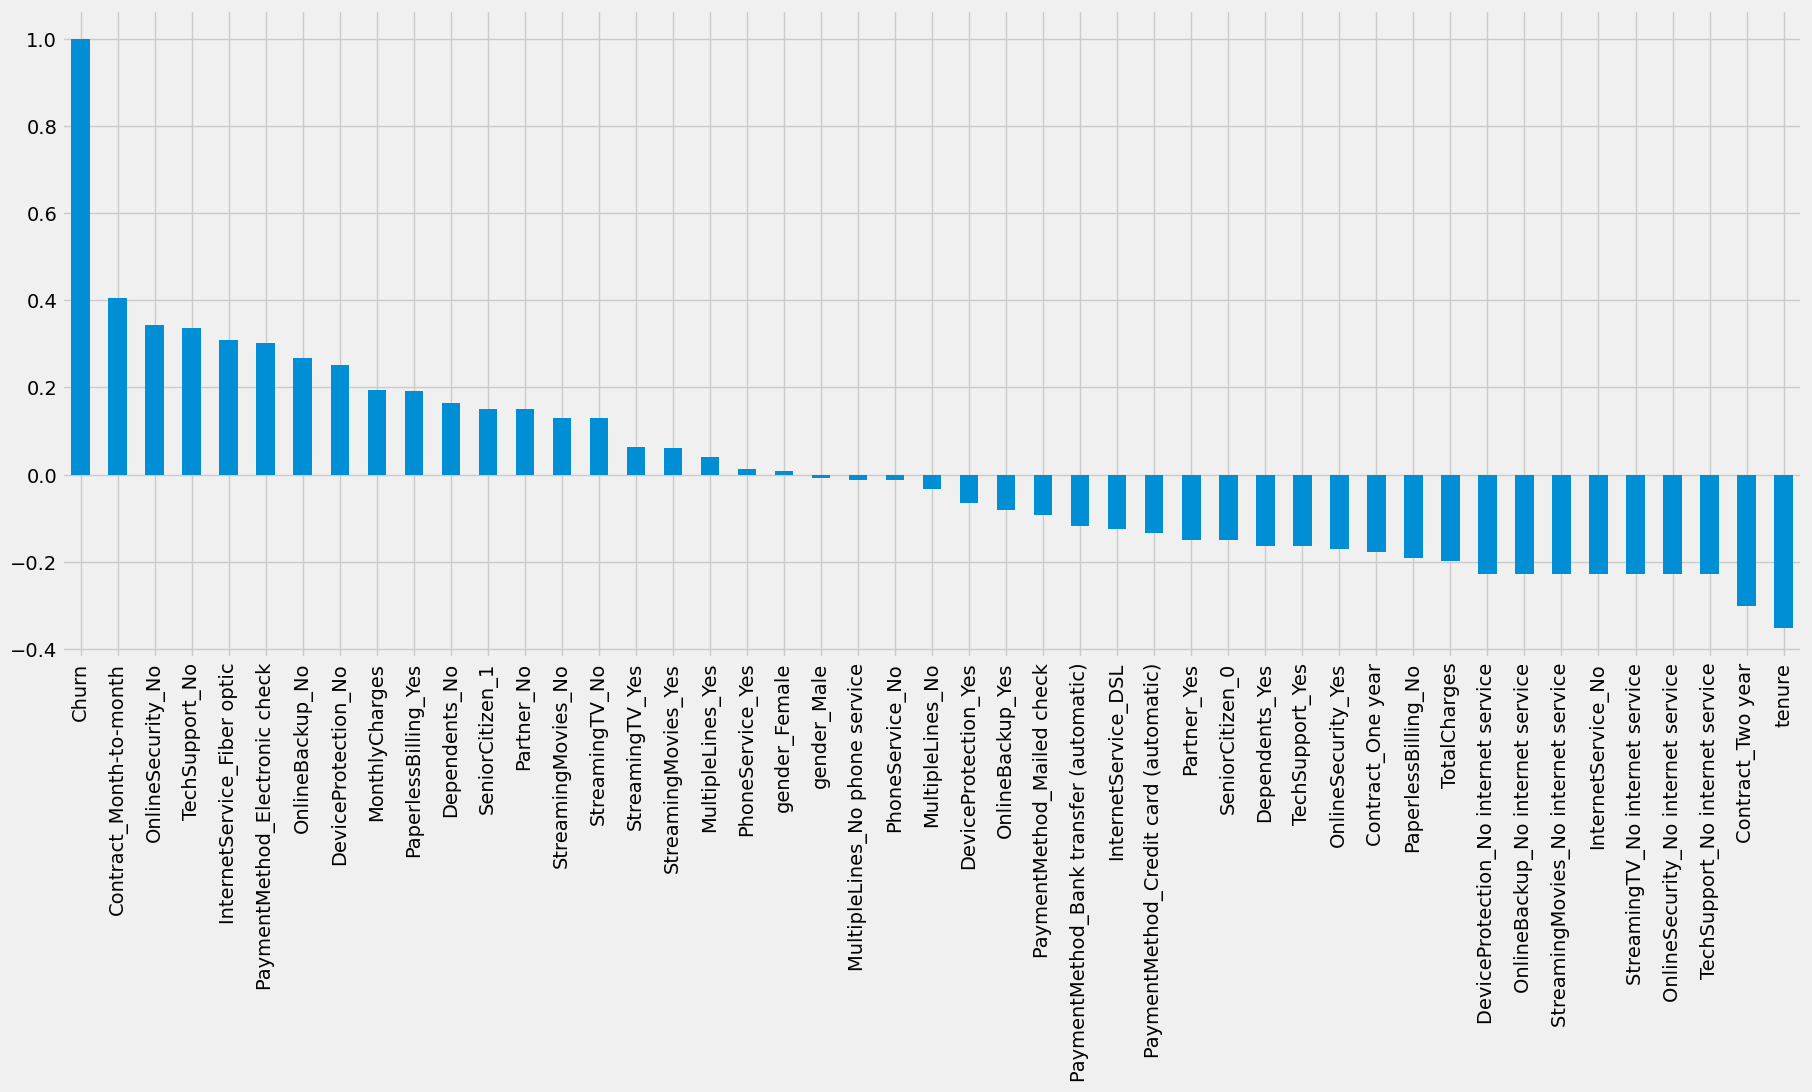

In [16]:
plt.figure(figsize=(20,8))
# Plotting all variable's correlations with churn in ascending order
data1.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

In [17]:
# 19 features
X2 = data2.loc[:, ['Contract_Month-to-month', 'OnlineSecurity_No', 'TechSupport_No', 
                   'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
                  'OnlineBackup_No', 'DeviceProtection_No', 'MonthlyCharges', 'PaperlessBilling_Yes',
                  'Dependents_No', 'SeniorCitizen_1', 'Partner_No', 'StreamingMovies_No', 'StreamingTV_No',
                  'StreamingTV_Yes', 'StreamingMovies_Yes', 'MultipleLines_Yes', 'PhoneService_Yes',
                  'gender_Female']]

# Inserting column of ones for XO parameter Q0
X2.insert(0, 'X0', 1)

In [18]:
params2 = np.zeros(X2.shape[1])

# Regularized Logistic Regression
parameters2, errors2 = log_reg_regularized_sgd(X2, target, params2, alpha, lamda, num_iters)

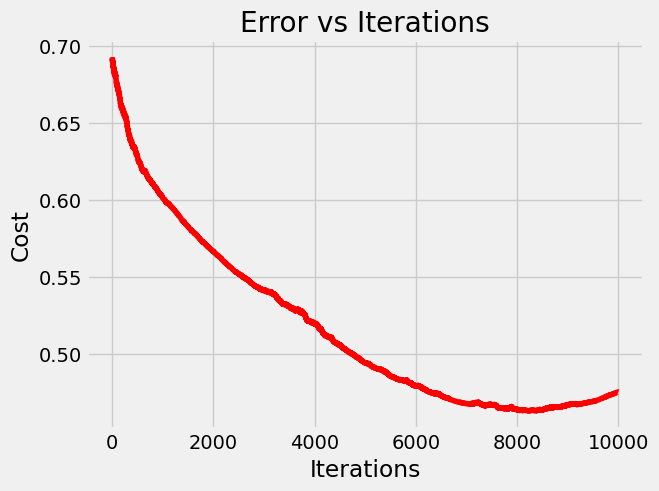

In [19]:
plotChart(num_iters, errors2)

#### Chose the correct metric for assessment of the model

In [20]:
y_predicted2 = predict(X2, parameters2)

# Converting predicted probabilities to binary labels
y_pred2 = (y_predicted2 >= 0.5).astype(int)

# Create confusion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(target, y_pred2).ravel()

# Calculate evaluation metrics
accuracy2 = accuracy_score(target, y_pred2)
precision2 = precision_score(target, y_pred2)
recall2 = recall_score(target, y_pred2)
f12 = f1_score(target, y_pred2)

# Print confusion matrix and evaluation metrics
print('Confusion Matrix:')
print('True Negative: ', tn2, '\tFalse Positive: ', fp2)
print('False Negative: ', fn2, '\tTrue Positive: ', tp2)

print('\nEvaluation Metrics: ')
print('Accuracy: ', accuracy2)
print('Precision: ', precision2)
print('Recall/Sensitivity: ', recall2)
print('F1 Score/Specificity: ', f12)

# Calculate AUC
auc2 = roc_auc_score(target, y_predicted2)
print('AUC: ', auc2)

Confusion Matrix:
True Negative:  4498 	False Positive:  676
False Negative:  896 	True Positive:  973

Evaluation Metrics: 
Accuracy:  0.7767996592361209
Precision:  0.5900545785324439
Recall/Sensitivity:  0.5205992509363296
F1 Score/Specificity:  0.5531552018192155
AUC:  0.8054203809101894


### Model 3: First n most influential variables with correlation > 0.2 (16 features)

In [21]:
corr_df = data1[data1.columns[0:]].corr()['Churn'][:]
np.abs(corr_df).sort_values(ascending=False)[1:20]

Contract_Month-to-month                 0.405103
tenure                                  0.352229
OnlineSecurity_No                       0.342637
TechSupport_No                          0.337281
InternetService_Fiber optic             0.308020
Contract_Two year                       0.302253
PaymentMethod_Electronic check          0.301919
OnlineBackup_No                         0.268005
DeviceProtection_No                     0.252481
StreamingMovies_No internet service     0.227890
StreamingTV_No internet service         0.227890
TechSupport_No internet service         0.227890
DeviceProtection_No internet service    0.227890
InternetService_No                      0.227890
OnlineBackup_No internet service        0.227890
OnlineSecurity_No internet service      0.227890
TotalCharges                            0.198324
MonthlyCharges                          0.193356
PaperlessBilling_Yes                    0.191825
Name: Churn, dtype: float64

In [22]:
# 5 features
X3 = data2.loc[:, ['Contract_Month-to-month', 'tenure', 'OnlineSecurity_No', 'TechSupport_No', 
                   'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check',
                   'OnlineBackup_No', 'DeviceProtection_No', 'StreamingMovies_No internet service',
                   'StreamingTV_No internet service', 'TechSupport_No internet service', 
                   'DeviceProtection_No internet service', 'InternetService_No', 
                   'OnlineBackup_No internet service', 'OnlineSecurity_No internet service']]

# Inserting column of ones for XO parameter Q0
X3.insert(0, 'X0', 1)

In [23]:
params3 = np.zeros(X3.shape[1])

# Regularized Logistic Regression
parameters3, errors3 = log_reg_regularized_sgd(X3, target, params3, alpha, lamda, num_iters)

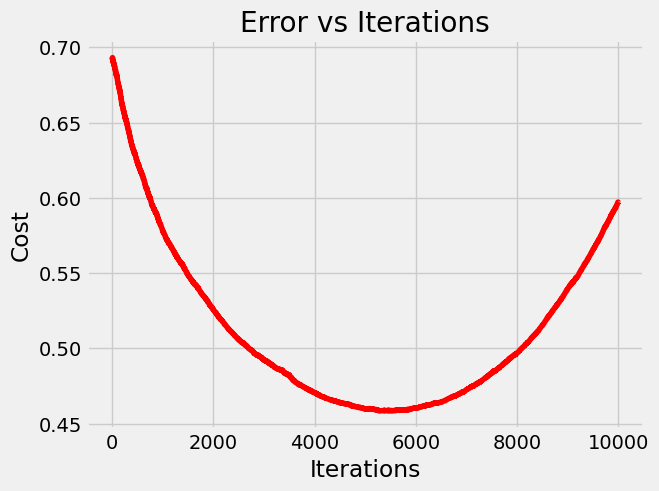

In [24]:
plotChart(num_iters, errors3)

#### Chose the correct metric for assessment of the model

In [25]:
y_predicted3 = predict(X3, parameters3)

# Converting predicted probabilities to binary labels
y_pred3 = (y_predicted3 >= 0.5).astype(int)

# Create confusion matrix
tn3, fp3, fn3, tp3 = confusion_matrix(target, y_pred3).ravel()

# Calculate evaluation metrics
accuracy3 = accuracy_score(target, y_pred3)
precision3 = precision_score(target, y_pred3)
recall3 = recall_score(target, y_pred3)
f13 = f1_score(target, y_pred3)

# Print confusion matrix and evaluation metrics
print('Confusion Matrix:')
print('True Negative: ', tn3, '\tFalse Positive: ', fp3)
print('False Negative: ', fn3, '\tTrue Positive: ', tp3)

print('\nEvaluation Metrics: ')
print('Accuracy: ', accuracy3)
print('Precision: ', precision3)
print('Recall/Sensitivity: ', recall3)
print('F1 Score/Specificity: ', f13)

# Calculate AUC
auc3 = roc_auc_score(target, y_predicted3)
print('AUC: ', auc3)

Confusion Matrix:
True Negative:  4465 	False Positive:  709
False Negative:  840 	True Positive:  1029

Evaluation Metrics: 
Accuracy:  0.7800653130768138
Precision:  0.5920598388952819
Recall/Sensitivity:  0.550561797752809
F1 Score/Specificity:  0.5705572497920711
AUC:  0.8153166540609373


### Model 4: 

In [26]:
services = ['PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 
            'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 
            'StreamingTV_Yes', 'StreamingMovies_Yes', 'PaperlessBilling_Yes']

X4 = data2.copy()
X4['ServicesCount'] = X4[services].apply(lambda x: x.sum(), axis=1)

# Inserting column of ones for XO parameter Q0
X4.insert(0, 'X0', 1)

In [30]:
params4 = np.zeros(X4.shape[1])

# Regularized Logistic Regression
parameters4, errors4 = log_reg_regularized_sgd(X4, target, params4, alpha, lamda, num_iters)

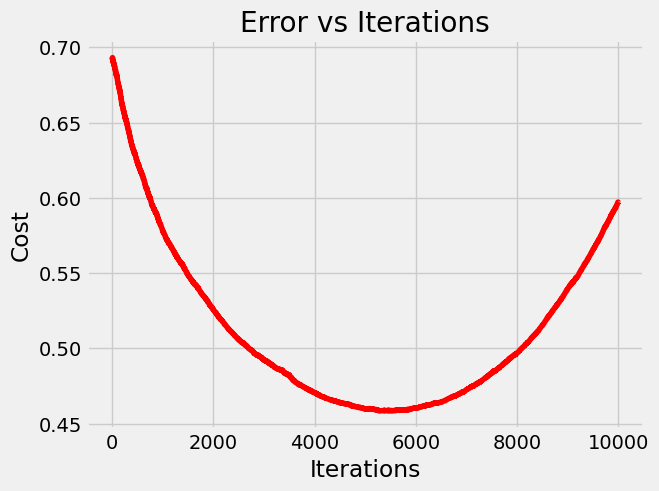

In [31]:
plotChart(num_iters, errors3)

#### Chose the correct metric for assessment of the model

In [32]:
y_predicted4 = predict(X4, parameters4)

# Converting predicted probabilities to binary labels
y_pred4 = (y_predicted4 >= 0.5).astype(int)

# Create confusion matrix
tn4, fp4, fn4, tp4 = confusion_matrix(target, y_pred4).ravel()

# Calculate evaluation metrics
accuracy4 = accuracy_score(target, y_pred4)
precision4 = precision_score(target, y_pred4)
recall4 = recall_score(target, y_pred4)
f14 = f1_score(target, y_pred4)

# Print confusion matrix and evaluation metrics
print('Confusion Matrix:')
print('True Negative: ', tn4, '\tFalse Positive: ', fp4)
print('False Negative: ', fn4, '\tTrue Positive: ', tp4)

print('\nEvaluation Metrics: ')
print('Accuracy: ', accuracy4)
print('Precision: ', precision4)
print('Recall/Sensitivity: ', recall4)
print('F1 Score/Specificity: ', f14)

# Calculate AUC
auc4 = roc_auc_score(target, y_predicted4)
print('AUC: ', auc4)

Confusion Matrix:
True Negative:  4677 	False Positive:  497
False Negative:  911 	True Positive:  958

Evaluation Metrics: 
Accuracy:  0.8000851909697572
Precision:  0.6584192439862543
Recall/Sensitivity:  0.512573568753344
F1 Score/Specificity:  0.5764139590854392
AUC:  0.8404010214466993
